In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [2]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['VN30INDEX']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2012-02-06,447.47,447.47,13467070,2.222420e+11,2062350,4.763552e+10,445.48,449.41,441.60,-1.94,-0.43
1,2012-02-07,449.31,449.31,17261070,3.021088e+11,2983896,5.689497e+10,448.37,450.13,443.38,1.84,0.41
2,2012-02-08,460.98,460.98,20406280,3.767460e+11,1662300,3.983639e+10,452.13,460.98,450.00,11.67,2.60
3,2012-02-09,464.73,464.73,20379320,3.655392e+11,6897257,1.480733e+11,466.75,468.14,461.49,3.75,0.81
4,2012-02-10,458.23,458.23,20816360,3.786271e+11,3156370,7.315004e+10,464.25,464.25,457.17,-6.50,-1.40
...,...,...,...,...,...,...,...,...,...,...,...,...
3184,2024-12-02,1308.83,1308.83,120795700,4.214727e+12,31567781,9.812760e+11,1315.77,1317.76,1303.51,-2.43,-0.19
3185,2024-12-03,1309.18,1309.18,161866500,5.139784e+12,82750679,2.189738e+12,1309.22,1312.00,1300.67,0.35,0.03
3186,2024-12-04,1297.81,1297.81,145211800,4.979389e+12,25845421,1.135317e+12,1304.48,1305.06,1297.49,-11.37,-0.87
3187,2024-12-05,1337.55,1337.55,275060000,8.206610e+12,21857923,1.072074e+12,1299.95,1337.55,1295.73,39.74,3.06


In [3]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3189 entries, 0 to 3188
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               3189 non-null   object 
 1   GiaDieuChinh       3189 non-null   float64
 2   GiaDongCua         3189 non-null   float64
 3   KhoiLuongKhopLenh  3189 non-null   int64  
 4   GiaTriKhopLenh     3189 non-null   float64
 5   KLThoaThuan        3189 non-null   int64  
 6   GtThoaThuan        3189 non-null   float64
 7   GiaMoCua           3189 non-null   float64
 8   GiaCaoNhat         3189 non-null   float64
 9   GiaThapNhat        3189 non-null   float64
 10  ThayDoi_GiaTri     3189 non-null   float64
 11  ThayDoi_PhanTram   3189 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 299.1+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,3189.000000,3189.000000,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3189.000000,3189.000000,3189.000000,3189.000000,3189.000000
mean,878.766758,878.929802,9.436326e+07,3.074415e+12,1.361148e+07,5.290109e+11,879.015472,885.037005,872.077902,0.322396,0.047012
std,305.391682,305.611093,8.269935e+07,3.465535e+12,1.913992e+07,8.116525e+11,305.908044,307.923809,303.348130,11.450702,1.187149
min,441.490000,441.490000,2.347200e+06,6.369023e+06,0.000000e+00,0.000000e+00,437.290000,443.500000,86.320000,-77.930000,-6.730000
25%,612.710000,612.710000,3.566146e+07,8.340880e+11,2.947580e+06,1.162612e+11,612.720000,616.510000,608.750000,-3.830000,-0.490000
50%,854.410000,854.410000,5.653758e+07,1.668157e+12,8.023260e+06,3.497048e+11,854.710000,860.100000,850.100000,0.860000,0.110000
75%,1109.270000,1109.630000,1.484503e+08,4.512755e+12,1.776046e+07,6.950476e+11,1112.500000,1119.760000,1100.110000,5.320000,0.680000
max,1572.460000,1572.460000,4.661564e+08,8.830891e+13,3.506417e+08,2.126690e+13,1576.740000,1587.000000,1567.670000,64.470000,5.310000


In [4]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

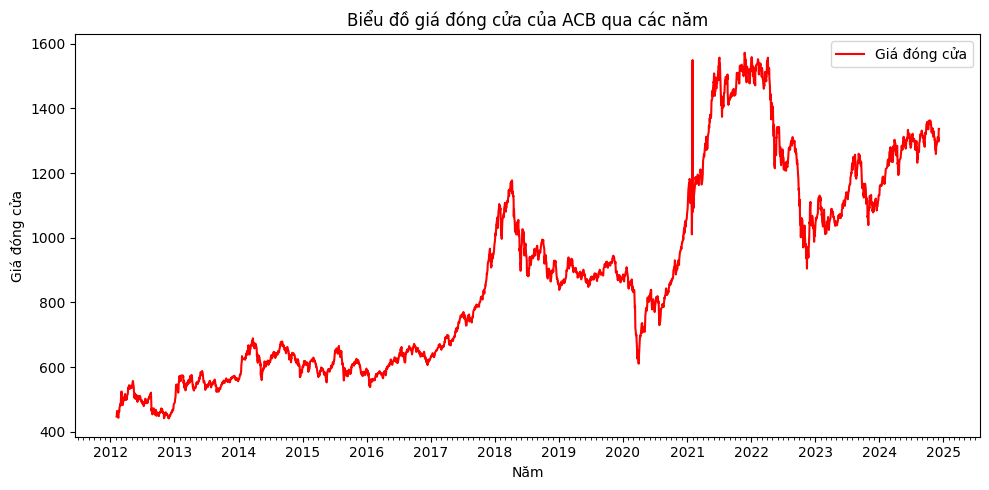

In [5]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của ACB qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [6]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [7]:
df1

,GiaDongCua
Ngay,
2012-02-06,447.47
2012-02-07,449.31
2012-02-08,460.98
2012-02-09,464.73
2012-02-10,458.23
...,...
2024-12-02,1308.83
2024-12-03,1309.18
2024-12-04,1297.81


In [8]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [9]:
data

array([[ 447.47],
       [ 449.31],
       [ 460.98],
       ...,
       [1297.81],
       [1337.55],
       [1337.28]])

In [10]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [11]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100

Epoch 1: loss improved from inf to 0.32760, saving model to save_models/VN30INDEX_model.keras
40/40 - 11s - 277ms/step - loss: 0.3276 - val_loss: 0.2146
Epoch 2/100

Epoch 2: loss improved from 0.32760 to 0.20671, saving model to save_models/VN30INDEX_model.keras
40/40 - 4s - 90ms/step - loss: 0.2067 - val_loss: 0.1653
Epoch 3/100

Epoch 3: loss improved from 0.20671 to 0.18848, saving model to save_models/VN30INDEX_model.keras
40/40 - 4s - 89ms/step - loss: 0.1885 - val_loss: 0.1552
Epoch 4/100

Epoch 4: loss improved from 0.18848 to 0.17452, saving model to save_models/VN30INDEX_model.keras
40/40 - 4s - 90ms/step - loss: 0.1745 - val_loss: 0.1440
Epoch 5/100

Epoch 5: loss improved from 0.17452 to 0.16278, saving model to save_models/VN30INDEX_model.keras
40/40 - 4s - 89ms/step - loss: 0.1628 - val_loss: 0.1360
Epoch 6/100

Epoch 6: loss improved from 0.16278 to 0.15407, saving model to save_models/VN30INDEX_model.keras
40/40 - 3s - 86ms/step - loss: 0.1541 - val_loss: 0

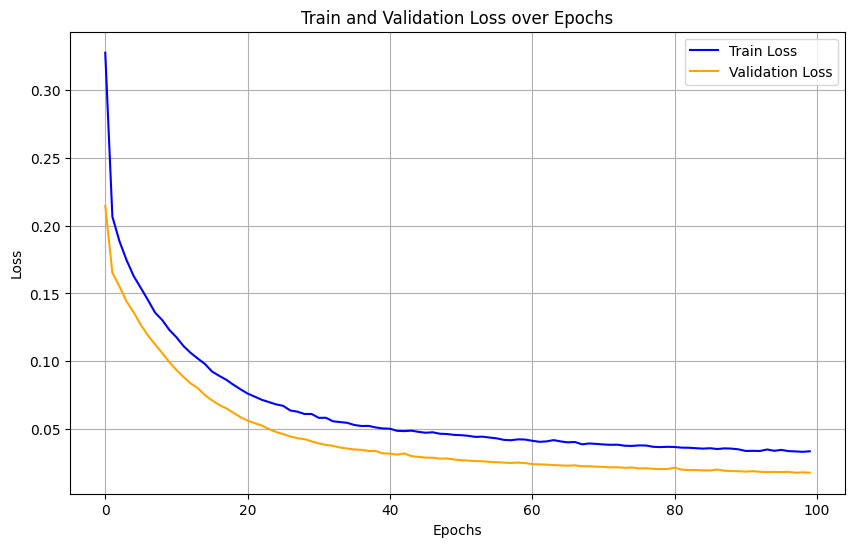

In [13]:
def build_model(input_shape):
    model = Sequential()
    
    # LSTM đầu tiên với L2 regularization
    model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True, 
                   kernel_regularizer=l2(0.001)))
    
    # LSTM thứ hai với L2 regularization
    model.add(LSTM(units=64, kernel_regularizer=l2(0.001)))
    
    # Tăng Dropout để giảm overfitting
    model.add(Dropout(0.35))
    
    # Lớp Dense để đưa ra kết quả dự đoán
    model.add(Dense(1))
    
    # Compile mô hình với learning rate thấp để ổn định huấn luyện
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001))
    
    return model

# Xây dựng mô hình
input_shape = (x_train.shape[1], x_train.shape[2])  # Điều chỉnh để phù hợp với đầu vào
model = build_model(input_shape)

# Đường dẫn lưu mô hình
save_model_path = "save_models/VN30INDEX_model.keras"

# Callbacks: ModelCheckpoint và EarlyStopping
callbacks = [
    ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=2)
]

# Huấn luyện mô hình và lưu kết quả vào history
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Thêm val_loss
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
save_model_path = "models/VN30INDEX_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [14]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


In [15]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[int(len(df) * 0.8):] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


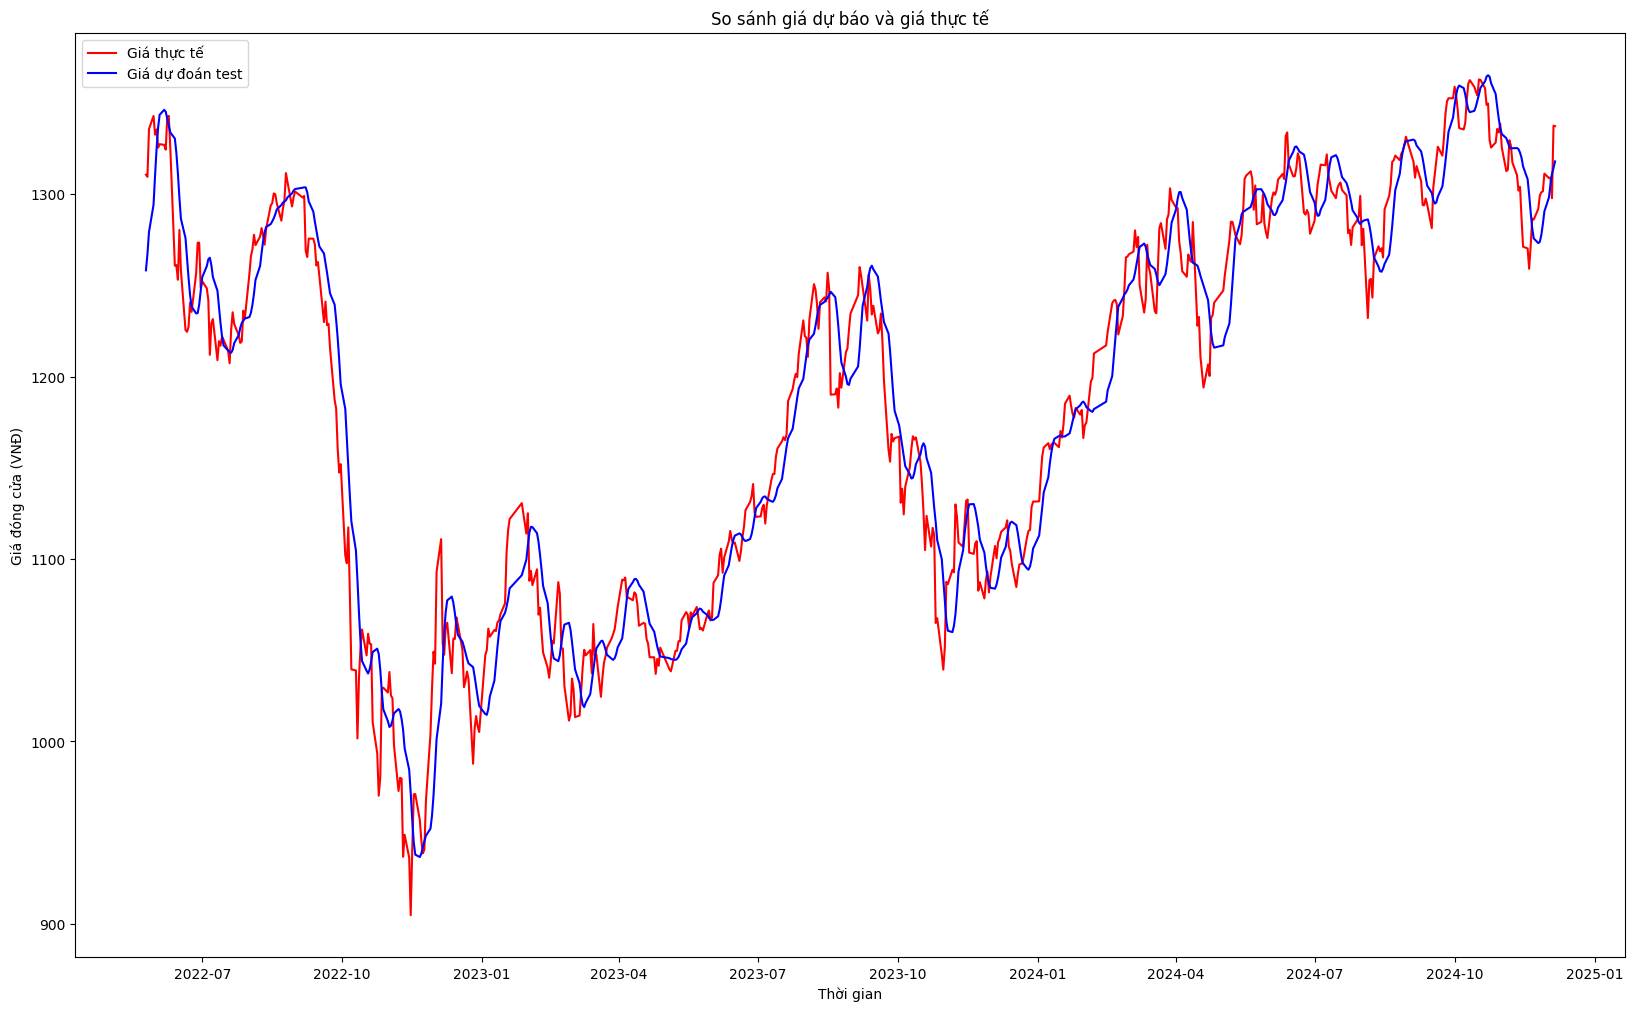

In [17]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [18]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9938561206970662
Sai số tuyệt đối trung bình trên tập train (VNĐ): 15.05234308961962
Phần trăm sai số tuyệt đối trung bình trên tập train: 1.8071987149421609
RMSE trên tập train (VNĐ): 22.71469278086088
Độ chính xác trên tập train (%): 97.99157424327251
F1 Score trên tập train: 1.0
----------------------------------------------------


In [19]:
y_test = data[-len(y_test_predict):]

In [20]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9367024971653996
Sai số tuyệt đối trung bình trên tập test (VNĐ): 21.841739796605605
Phần trăm sai số tuyệt đối trung bình trên tập test: 1.8713118466777539
RMSE trên tập test (VNĐ): 27.36966947089994
Độ chính xác trên tập test (%): 94.02565496575134
F1 Score trên tập test: 1.0
----------------------------------------------------
